In [1]:
import torch
import torch.nn as nn

We will begin by making the model, which will be used later within the TF API. In this small example, we will be experimenting with different methods for random initialization of the embeddings, exploring how they may impact learning speed. So, we will use "init_func" as a placeholder for a generic initialization function.

Please FILL_IN the code below with relevant code to make this notebook run.

In [2]:
FILL_IN = 'FILL_IN'

In [3]:
V = 5000
E = 50

class MFEmbedder(nn.Module):
    def __init__(self, vsize, embdim):
        super(MFEmbedder, self).__init__()
        # Make B a Parameter which has floats of dimension vsize, embdim.
        # Same for A.
        self.B = nn.Parameter(torch.rand(vsize, embdim))
        self.A = nn.Parameter(torch.rand(vsize, embdim))
        
        nn.init.normal_(self.B)
        nn.init.normal_(self.A)
   
    def forward(self, x=None):
        # This should return BA^T, which is qual to the shifted PMI matrix.
        return self.B @ self.A.T
    

In [4]:
model = MFEmbedder(V, E)

Now we need to make the special loss function that we learned to derive from last time. With this made, we will now be ready to learn SGNS vectors!

This loss should be the loss in lecture. For the positive term it should be $N_{ij} \log {\sigma{(b_j^{\intercal}a_i)}}$ and similarly for the negative (see lecture). pos_samples should be a scalar, same for negative samples.

Remember, we assume $b_j^{\intercal}a_i = M_{ij}$ due to optimality.

In [5]:

class SGNSLoss():
    def __init__(self, Nij, Ni, Nj, N, K):
        self.Nij = Nij
        self.Ni = Ni
        self.Nj = Nj
        self.N = N
        self.K = K
        
    def __call__(self, BA):
        pos_samples = torch.sum(self.Nij * nn.LogSigmoid()(BA))
        
        # This should be a 1 by 1 matrix.
        
        neg_samples = torch.sum(self.K * (self.Ni.unsqueeze(1) @ self.Nj.unsqueeze(1).T) / self.N * nn.LogSigmoid()(-BA))
        
        
        return -(pos_samples + neg_samples) / self.N


Now we should declare some of the variables that we want to work with. We are going to need to load one of my pre-made files that performs cooccurrence statistic extraction. Because this is a small example, we will just be using a 5000 word vocabulary so that we don't overload Google's cloud GPUs.

In [6]:
## Boring data downloading stuff.
import requests
import io
import zipfile
import pandas as pd

def download_extract_zip(file_name):
    with zipfile.ZipFile(file_name, 'r') as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                return pd.read_csv(
                    thefile, 
                    sep=' ', 
                    header=None, 
                    names=['term', 'context', 'Nij']
                )

df = download_extract_zip('cooc.zip') 

In [7]:
df.head()

,term,context,Nij
0,chief,peace,2072.8
1,produces,venezuela,109.4
2,resources,?,411.2
3,israelis,later,196.2
4,however,list,1395.2


In [8]:

for tup in df.itertuples(): 
    print(tup)
    break

Pandas(Index=0, term='chief', context='peace', Nij=2072.8)


In [9]:
# Now we are loading in the data from the dataframe (quick and kind of dirty).
vocab = {"<unk>": 0}
invvocab = ["<unk>"]

from collections import defaultdict
counts = defaultdict(float)

# Fill in counts so that for each term  you get the count of the term.
for tup in df.itertuples(): 
    counts[tup.term] += tup.Nij

for w in sorted(counts.keys(), key=lambda x: -counts[x]):
    # Update the vocab and invocab maps.
    vocab[w] = len(invvocab)
    invvocab.append(w)

# Let thi be the length of vocab. Should be 5000
V = len(vocab)

# Given the vocabulary mapping above, we now fill in the Nij matrix.
# NOTE - with large vocabs, this should be done using a *sparse* matrix!!!
import numpy as np
# Make this a numpy array of V and V, fill of zeros.
Nij_np = np.zeros((V, V))
for tup in df.itertuples():
    # Fill in with the int token for the term in tup.
    i = vocab[tup.term]
    # Fill in with the int token for the context in tup.
    j = vocab[tup.context]
    # Fill in with the count in tup.
    Nij_np[i, j] = tup.Nij

In [10]:
# NOTE: The data was a collection has a small issue so the row and column sums are not quite equal. This is fine.

Nij = torch.tensor(Nij_np, dtype=torch.float32)
# marginalize to get the unigram counts
N = torch.sum(Nij)

# col sums
Ni = torch.sum(Nij, dim=0)

# row sum
Nj = torch.sum(Nij, dim=1)

In [11]:
# Get the PMI matrix. Don't use einsum, but the _check version is one way to get what you want.
PMI_np_check = np.array(torch.log((N * Nij) / (torch.einsum('i,j->ij', Ni, Nj))))

PMI_np = np.array(torch.log((N * Nij) / (Ni.unsqueeze(1) @ Nj.unsqueeze(1).T)))

In [12]:
# Check the denominators are equal.
assert(torch.all(
    torch.eq(
        torch.einsum('i,j->ij', Ni, Nj),
        (Ni.unsqueeze(1) @ Nj.unsqueeze(1).T)
)).item())

Let's do a sanity check and examine the count statistics with some cool matplotlib visualizations.

You should see about 75% of the M matrix is zero.

Percent -infinities in the PMI matrix: 75.0882%
Statistics of PMIs: 
0.1405 mean, 1.0462 std


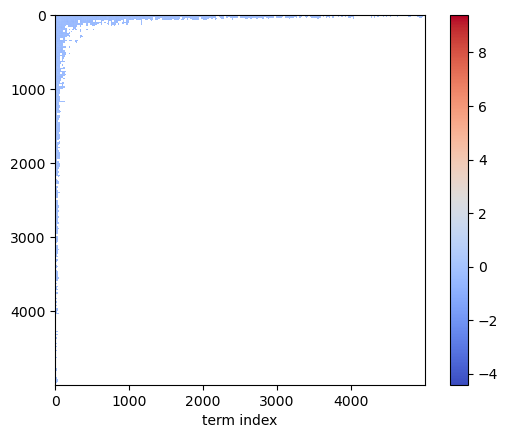

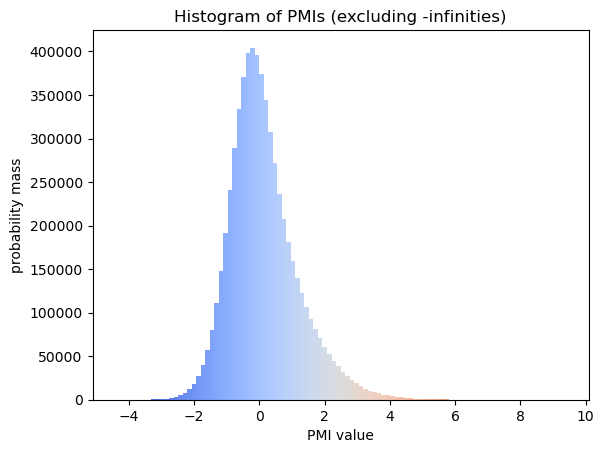

In [13]:
from matplotlib import pyplot as plt
# Investigate some of the statistics.
flat_PMI_np = PMI_np.reshape(-1)
pmi_negativeinf = np.sum(flat_PMI_np == -np.inf)
total = np.prod(PMI_np.shape)
print('Percent -infinities in the PMI matrix: {:.4f}%'.format(
    100 * pmi_negativeinf / total))

# Visualize the matrix!
_ = plt.figure()
_ = plt.imshow(PMI_np, cmap="coolwarm")
_ = plt.xlabel("term index")
_ = plt.colorbar()

# Turn the -infinities to something easier to work with.
PMI_np[PMI_np == -np.inf] = -4
PMI_np[np.isnan(PMI_np)] = -4
hist_pmis = flat_PMI_np[flat_PMI_np != -4]
_ = plt.figure()
n, bins, patches = plt.hist(hist_pmis, 
                            bins=100,              
                            color="b",
                            alpha=1)
print("Statistics of PMIs: ")
print("{:0.4f} mean, {:0.4f} std".format(np.mean(hist_pmis), 
                                         np.std(hist_pmis)))

# Add shading to the histogram.
cm = plt.cm.get_cmap("coolwarm")
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
_ = plt.xlabel("PMI value")
_ = plt.ylabel("probability mass")
_ = plt.title("Histogram of PMIs (excluding -infinities)")

In [14]:
""" 
Note that there was a slight bug when extracting corpus statistics,
since the context window (w=5) is symmetric, PMI(i,j) should always equal
PMI(j,i); however, due to improper handling of context during the first 5 words
of a document, the statistics are ever-so-slightly distorted.
"""
# look at the biggest PMIs
sorted_ind = np.argsort(PMI_np, axis=None)

print('--- Word pairs with the notable PMIs ---\n')
for i in range(1, 18):
    ind = np.unravel_index(sorted_ind[-i], PMI_np.shape)
    term, context = invvocab[ind[0]], invvocab[ind[1]]
    print('{:8} {:14} (PMI = {:0.4f})'.format(term, context, float(PMI_np[ind])))

--- Word pairs with the notable PMIs ---

|        |              (PMI = 9.3956)
puerto   rico           (PMI = 8.9212)
rico     puerto         (PMI = 8.9182)
las      vegas          (PMI = 8.7001)
vegas    las            (PMI = 8.6940)
bin      laden          (PMI = 8.3084)
optional trim           (PMI = 8.3080)
trim     optional       (PMI = 8.3073)
laden    bin            (PMI = 8.2967)
sri      lanka          (PMI = 8.1917)
lanka    sri            (PMI = 8.1655)
jacques  chirac         (PMI = 8.1147)
chirac   jacques        (PMI = 8.0814)
makeup   racial         (PMI = 8.0538)
racial   makeup         (PMI = 8.0533)
composite nasdaq         (PMI = 8.0391)
nasdaq   composite      (PMI = 8.0328)


In [15]:
# Create the object representing the loss function. Use SGNSLoss with K = 1.
criterion = SGNSLoss(K=1,Nij = Nij,Ni=Ni,Nj=Nj,N=N)

# desired embedding dimensionality
E = 50

# Create the MF model!
model = MFEmbedder(V, E)

# Instantiate optimizer using Adam and learning rate 0.1
optimizer = torch.optim.Adam(lr=0.1, params=model.parameters())


Here we want to do the unconstrained optimization. 

In [16]:
def train_step(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    optimizer.zero_grad()
    # This is B @ A.t().
    BA = model()
    loss = criterion(BA)
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
model.B.shape

torch.Size([5000, 50])

In [18]:
# Grabs the most similar words to the current term. We scale the vectors and then do an inner product.
def most_similar(term):
    # Grab the token index for the term.
    i = vocab[term]
    # Grab the vector for the token i from the B matrix.
    emb = model.B[i]
    # Normalize the embeddings.
    embs = model.B/torch.sum(model.B**2, dim=1).unsqueeze(-1)
    # Get all the cosine similarities between the emb and embs.
    #cossims = torch.sum(emb * embs, dim=1).detach().numpy()
    cossims = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), embs, dim=1).detach().numpy()
    print(cossims.shape)
    # Find the clostest words, sort by cossims.
    wordsims = sorted(invvocab, key=lambda x: -cossims[invvocab.index(x)])
    # Get the top 6 words. Use invvoc.
    return wordsims[1:7]
# first is the word itself

In [19]:
# Now run a training loop! Note that these embeddings will be trained in less
# than 15 minutes - much much much faster than it would take for the original 
# implementation. But, the speed of this is dependent on the vocabulary size.
import time

start = time.process_time() 
estart = time.process_time() 
results = []

n_iters = 500 + 1
print_every = 50

for i in range(n_iters): 
    loss = train_step(model, optimizer)
    results.append(loss)
    if i % print_every == 0:
        print('\nstep {:4} - loss: {} ({:0.4f} seconds)'.format(
            i, results[-1], time.process_time()  - estart)
             )
        print('\t similar to \"money\": '+" ".join(most_similar("money")))
        print('\t similar to \"peace\": '+" ".join(most_similar("peace")))

        estart = time.process_time() 
        
print('\nTotal time: {:0.4f} seconds.'.format(time.process_time()  - start))


step    0 - loss: 5.895988941192627 (0.9961 seconds)
(5000,)
	 similar to "money": resulting widespread our vietnam troops level
(5000,)
	 similar to "peace": championship revenues producing color boris 2.5

step   50 - loss: 1.31708562374115 (35.9246 seconds)
(5000,)
	 similar to "money": attract sell check almost longer if
(5000,)
	 similar to "peace": aid helping future tehran plan secure

step  100 - loss: 1.290933609008789 (35.7387 seconds)
(5000,)
	 similar to "money": cash compensation attract pension funds assets
(5000,)
	 similar to "peace": arab negotiations peaceful syria accord treaty

step  150 - loss: 1.2867798805236816 (35.6989 seconds)
(5000,)
	 similar to "money": cash compensation customers funds savings credit
(5000,)
	 similar to "peace": negotiations peaceful syria accord israel treaty

step  200 - loss: 1.2853152751922607 (35.8034 seconds)
(5000,)
	 similar to "money": cash funds tax compensation customers savings
(5000,)
	 similar to "peace": negotiations accord

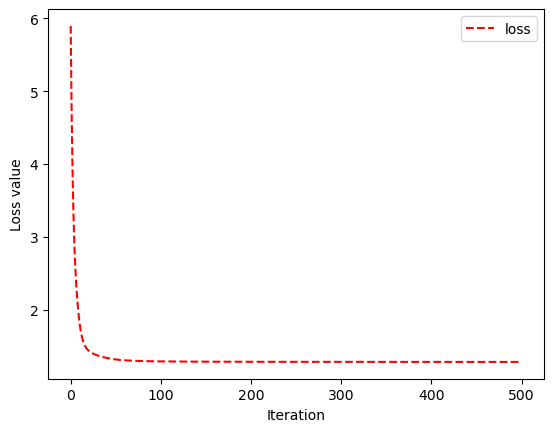

In [20]:
# Let's look at the loss over time.
from matplotlib import pyplot as plt
x = np.array(list(range(len(results))))
y = np.array(results)

# use the underscore to avoid printing to colab
_ = plt.figure()
_ = plt.plot(x, y, '--r', label="loss")
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss value")
# _ = plt.title("MF-SGNS loss over time")
_ = plt.legend()

Training is finished, and it looks like the model is learning to produce vectors with desirable semantic qualities! The loss is descreasing as well. As a final sanity check, let's do a manual inspection of a few more words, just to double check. 

In [21]:
# More maual inspection.
# You should see that this makes sense as below.
for w in ["drive", "america", "east", "soviet", "belgium", "brussels", "1914"]:
    print("{:10}: {}".format(w, " ".join(most_similar(w))))

(5000,)
drive     : stop catch landing road pull ride
(5000,)
america   : europe africa asia canada mexico japan
(5000,)
east      : west southeast north southern eastern northeast
(5000,)
soviet    : communist allied yugoslav russian german yugoslavia
(5000,)
belgium   : denmark austria sweden norway greece italy
(5000,)
brussels  : rome vienna belgium paris munich geneva
(5000,)
1914      : 1939 1915 1917 1916 1920 1940
